In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

runs = pd.read_pickle("Data/main_1.df")

feats = ['actual_weight','declared_weight','draw','win_odds','jockey_ave_rank','trainer_ave_rank',
'recent_ave_rank','distance']
feat_1 = ["horse_no", "horse_age", "horse_rating", "declared_weight", "actual_weight", 
            "win_odds", "draw", "race_size", "distance", "race_class", 
            'last_race_result','win_percent', 
            'avg_distance_time', 'normal_avg_distance_time',
            'going_type_record', 'actual_weight_scaled',
            'declared_weight_scaled', 'horse_race_count', "jockey_record",
            'trainer_record', 'horse_record', 'surface_record', 'place_odds',
            'weight_change', 'weight_change_over_time','weight_change_from_average', 'weight_change_increase',
            'venue_change','venue_record', 'days_since_last_race', 'new_horse',
            'best_odds', 'best_win_percent', 'best_distance_time', 'best_going_record', 
            'best_horse_record', 'best_jockey_record','best_trainer_record', 'highest_actual_weight', 
            'lowest_actual_weight', 'start_speed', 'rode_before',
           'horse_type_Brown',
           'horse_type_Colt', 'horse_type_Filly', 'horse_type_Gelding',
           'horse_type_Grey', 'horse_type_Horse', 'horse_type_Mare',
           'horse_type_Rig', 'horse_type_Roan', 'horse_country_ARG',
           'horse_country_AUS', 'horse_country_BRZ', 'horse_country_CAN',
           'horse_country_FR', 'horse_country_GB', 'horse_country_GER',
           'horse_country_GR', 'horse_country_IRE', 'horse_country_ITY',
           'horse_country_JPN', 'horse_country_NZ', 'horse_country_SAF',
           'horse_country_SPA', 'horse_country_USA', 'horse_country_ZIM',
          'going_type_fast', 'going_type_slow', 'going_type_wet'
           ]

In [2]:
# runs['jockey_ave_rank'] = '7'
# jockey = runs.jockey_id.unique()
# for i in range(len(jockey)):
#     temp = runs[runs.jockey_id == jockey[i]]['result']
#     temp = temp.values.tolist()
#     if len(temp) != 0:
#         temp_int = map(int,temp)
#         temp_ave = np.mean(temp)
#         runs['jockey_ave_rank'][runs.jockey_id == jockey[i]] = temp_ave


# runs['trainer_ave_rank'] = '7'
# trainer = runs.trainer_id.unique()
# for i in range(len(trainer)):
#     temp = runs[runs.trainer_id == trainer[i]][['result']]
#     temp = temp.values.tolist()
#     if len(temp) != 0:
#         temp_int = map(int,temp)
#         temp_ave = np.mean(temp)
#         runs['trainer_ave_rank'][runs.trainer_id == trainer[i]] = temp_ave
    
# runs['recent_ave_rank'] = 7.0

# for i in range(1, len(runs['result'])):
    
#     temp = runs[ : (i - 1)][runs.horse_id == runs.horse_id[i]]['result']
#     temp = temp.values.tolist()
    
#     if len(temp) != 0:
#         if len(temp)<7:
#             runs['recent_ave_rank'][i] = float(np.mean(temp))
#         else:
#             runs['recent_ave_rank'][i] = np.mean(temp[-6:])
            
# runs.to_pickle("Data/main_1.df")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
def winnerEval(model, x_test, y_test, target, race_sizes):
    # convert preds into an actual win choice
    winPreds = model.predict_proba(x_test)[:, 1]
    winCount = 0
    temp = 0 
    for i, s in enumerate(race_sizes):
        low_index = temp
        high_index = temp + s
        
        racePreds = winPreds[low_index:high_index]
        raceVals = y_test[low_index:high_index]
        
        if target=="HorseWin":
            predWinner = np.argmax(racePreds, axis=0)
            actWinner = np.argmax(raceVals, axis=0)

            if predWinner == actWinner:
                winCount += 1
            
        elif target=='HorseRankTop3':
            predPlacers = racePreds.argsort()[-3:]
            actPlacers = raceVals.argsort()[-3:]
            
            for val in actPlacers:
                if val in predPlacers:
                    winCount+=1
                    
        else:
            tc = 0 
            half = int(len(racePreds)/2.)
            predPlacers = racePreds.argsort()[-half:]
            actPlacers = raceVals.argsort()[-half:]
            
            for val in actPlacers:
                if val in predPlacers:
                    tc+=1
                    
            if tc!=0:
                winCount += tc/float(half)
                    
        temp += s
        
    if target=='HorseWin':
        return winCount/float(len(race_sizes))
    elif target=="HorseRankTop3":
        return winCount / float(len(race_sizes)*3)
    else:
        return winCount /float(len(race_sizes))
    
def crossVal(dat, feat, target, model, skipPct=0, n_folds=4):
    
    dat = dat.copy()
    race_ids = np.unique(dat["race_id"])
    cv = KFold(n_splits=n_folds, shuffle=True)
    scores = []
    count = 1
    for train_races, test_races in cv.split(race_ids):
        #print("CV {}/{}".format(count, n_folds))
        train_r = race_ids[train_races]
        test_r = race_ids[test_races]
        X_train = dat.loc[dat["race_id"].isin(train_r)][feat]
        y_train = dat.loc[dat["race_id"].isin(train_r)][target]
        X_test = dat.loc[dat["race_id"].isin(test_r)][feat]
        y_test = dat.loc[dat["race_id"].isin(test_r)][target]
        
        model.fit(X_train, y_train)
        
        testDat = dat.loc[dat["race_id"].isin(test_r)]
        testGroups = [len(testDat.loc[testDat["race_id"]==race_id]) for race_id in np.unique(testDat["race_id"])]
        scores.append(winnerEval(model, X_test, y_test, target, testGroups))
        count += 1
        
    meanScore = np.mean(scores)
    stdScore = np.std(scores)
    
    print("Mean score: {:.3f} +/- {:.3f}".format(meanScore, stdScore))
    
    return meanScore, stdScore


def getCrossVal(data, n_folds):
    
    from sklearn.model_selection import KFold
    
    u_races = np.unique(data["race_id"])
    cv = KFold(n_splits=n_folds, shuffle=True)
    race_splits = [(train, test) for train, test in cv.split(u_races)]
    
    # Convert race ids to run indexes
    run_splits = [(data.loc[data["race_id"].isin(u_races[train_r])],
                   data.loc[data["race_id"].isin(u_races[test_r])]) for train_r, test_r in race_splits]
    
    return run_splits

############################################# BETTING #############################################

def makeBets_1(model, X_train, y_train, testing_in, X_test, y_test, target, betSize=1, startMoney=100):
    # Fit and predict
    testing = testing_in.copy()
    betSize = float(betSize)
    model.fit(X_train, y_train)
    testing["predictions"] = model.predict(X_test)
    print(sum(testing["predictions"]))
    
    money = [startMoney]
    
    count = 0
    for i, r in enumerate(np.unique(testing["race_id"])):
        act = testing.loc[testing["race_id"]==r][target]
        odds = testing.loc[testing["race_id"]==r]["win_odds"]
        preds = testing.loc[testing["race_id"]==r]["predictions"]
        
        #odds = testing.iloc[lowI:highI, :]["win_odds"]
        newMoney = money[-1]
        
        if newMoney < 1: # if we run out of money
            #money = money + list(np.zeros(len(test_race_sizes[i:])))
            return money

        if sum(preds)==1: # One win, bet on it
            win_horse_i = np.argmax(preds)
            if act.iloc[win_horse_i]==betSize:
                newMoney = money[-1] - betSize + betSize*odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - betSize
                
        elif sum(preds)>1: # more than one win, find lowest odds one and bet on it
            win_horse_i = np.argmin(odds.iloc[np.where(preds==1)])
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - betSize + betSize*odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - betSize
            
        money.append(newMoney) 
        
    return money

63493 15954
0
63586 15861
6416
63615 15832
0
63523 15924
3046
63571 15876
0


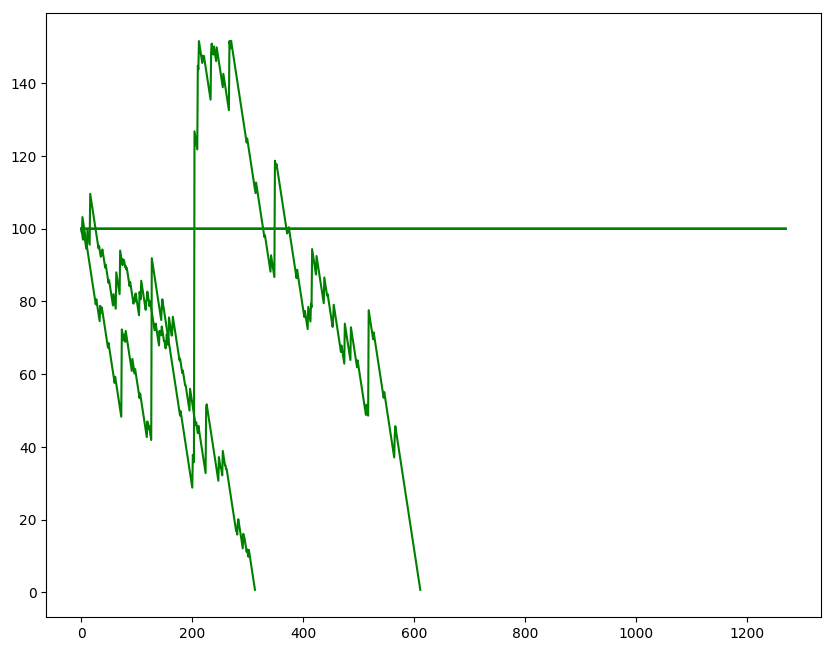

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
# Test it
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
targs = "won"
kfold = KFold(n_splits = 5)

plt.figure(figsize=(10,8), dpi=100)

for training, testing in getCrossVal(runs, 5):
    model = MLPClassifier(
        solver="adam",
        activation="identity",
        hidden_layer_sizes=(int(len(feat_1)/2)),
        alpha=0.002, 
        learning_rate="constant",
    )
    
    X_train = training[feats]
    y_train = training[targs]
    X_test = testing[feats]
    y_test = testing[targs]
    target = targs
    
    print(len(X_train), len(X_test))
    
    n = makeBets_1(model, X_train, y_train, testing, X_test, y_test, target, betSize=1, startMoney=100)
    plt.plot(n, "g")

In [5]:
model = GaussianNB()
cross_val_score(model)
cross_val_score(lr_model,X_train,y_train['HorseWin'],cv = kfold,scoring = 'f1')

TypeError: cross_val_score() missing 1 required positional argument: 'X'

In [ ]:
runs[feats].head(20)

In [8]:
len(runs)

79447